In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Data 

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=4000)

word_index = tf.keras.datasets.imdb.get_word_index()
index2word = dict((i + 3, word) for (word, i) in word_index.items())
index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'
x_train = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train])
x_test = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test])

1641221/1641221 [==============================] - 0s 0us/step


In [3]:
len(word_index)

88584

In [4]:
x_train[0]

"[bos] this film was just brilliant casting location scenery story direction [oov] really suited the part they played and you could just imagine being there robert [oov] is an amazing actor and now the same being director [oov] father came from the same [oov] island as myself so i loved the fact there was a real connection with this film the witty [oov] throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for [oov] and would recommend it to everyone to watch and the fly [oov] was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also [oov] to the two little [oov] that played the [oov] of norman and paul they were just brilliant children are often left out of the [oov] list i think because the stars that play them all grown up are such a big [oov] for the whole film but these children are amazing and should be [oov] for what they have done 

In [5]:
vocabulary = list()
for text in x_train:
  tokens = text.split()
  vocabulary.extend(tokens)

vocabulary = set(vocabulary)
print(len(vocabulary))

3998


In [6]:
from tqdm import tqdm

x_train_binary = list()
x_test_binary = list()

for text in tqdm(x_train):
  tokens = text.split()
  binary_vector = list()
  for vocab_token in vocabulary:
    if vocab_token in tokens:
      binary_vector.append(1)
    else:
      binary_vector.append(0)
  x_train_binary.append(binary_vector)

x_train_binary = np.array(x_train_binary)

for text in tqdm(x_test):
  tokens = text.split()
  binary_vector = list()
  for vocab_token in vocabulary:
    if vocab_token in tokens:
      binary_vector.append(1)
    else:
      binary_vector.append(0)
  x_test_binary.append(binary_vector)

x_test_binary = np.array(x_test_binary)

100%|██████████| 25000/25000 [05:30<00:00, 75.75it/s]


##Class BernoulliNaiveBayes

In [7]:
class BernoulliNaiveBayes:
    def __init__(self):
        self.classes = None 
        self.likelihoods = None
        self.p_of_class = None
        
    def fit(self, X, y):
        n_reviews, n_words = X.shape 
        self.classes = np.unique(y) #classes=[0(neg),1(pos)]
        n_classes = len(self.classes)
        
        self.p_of_class = np.zeros(n_classes)
        self.likelihoods = np.zeros((n_classes, n_words))
        
        for c in self.classes:
            X_c = X[y == c]
            self.p_of_class[c] = X_c.shape[0] / float(n_reviews) #p_of_class=[P(neg)=1/2,P(pos)=1/2]
            for f in range(n_words):
                word_count = X_c[:, f].sum() #Syxnothta kathe word se ola ta reviews ana kathgoria neg/pos
                self.likelihoods[c, f] = (word_count + 1) / (X_c.shape[0] + 2)#Pithanothtes kathe word gia neg kai pos xrhshmopoiwntas ektimhtria Laplace
                
    def predict(self, X):
        n_reviews, _ = X.shape
        y_pred = np.zeros(n_reviews)
        for i in range(n_reviews):
            finals = []
            for c in self.classes:
                plog= np.log(self.p_of_class[c])#log(P(c))
                likelihood = np.sum(np.log(self.likelihoods[c, X[i] == 1])) # Sum pithanothtwn ton words tou review 
                final = plog + likelihood
                finals.append(final)
            y_pred[i] = self.classes[np.argmax(finals)]
        return y_pred

In [8]:
b = BernoulliNaiveBayes()
b.fit(x_train_binary, y_train)
from sklearn.metrics import classification_report
print(classification_report(y_test, b.predict(x_test_binary)))


              precision    recall  f1-score   support

           0       0.79      0.90      0.84     12500
           1       0.88      0.76      0.82     12500

    accuracy                           0.83     25000
   macro avg       0.84      0.83      0.83     25000
weighted avg       0.84      0.83      0.83     25000



Dev var

In [9]:
from sklearn.model_selection import train_test_split
# split rest of the train data into train and dev
x_train_binary, x_dev_binary, y_train, y_dev = train_test_split(x_train_binary, y_train,
                                                                test_size=0.3)

Diagram 

(3500, 3998)
(3500,)
(7000, 3998)
(7000,)
(10500, 3998)
(10500,)
(14000, 3998)
(14000,)
(17500, 3998)
(17500,)


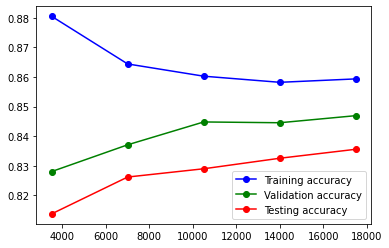

In [10]:
from sklearn.metrics import accuracy_score
def custom_learning_curve(x_train, y_train,
                          x_val, y_val, x_test, y_test,
                          n_splits):
  
  split_size = int(len(x_train) / n_splits)
  x_splits = np.split(x_train, n_splits) # must be equal division
  y_splits = np.split(y_train, n_splits)
  train_accuracies = list()
  val_accuracies = list()
  test_accuracies = list()
  curr_x = x_splits[0]
  print(curr_x.shape)
  curr_y = y_splits[0]
  print(curr_y.shape)
  b = BernoulliNaiveBayes()
  b.fit(curr_x, curr_y)
  train_accuracies.append(accuracy_score(curr_y, 
                                         b.predict(curr_x)))
  
  val_accuracies.append(accuracy_score(y_val, b.predict(x_val)))
  test_accuracies.append(accuracy_score(y_test, b.predict(x_test)))

  for i in range(1, len(x_splits)):
    b = BernoulliNaiveBayes()
    curr_x = np.concatenate((curr_x, x_splits[i]), axis=0)
    print(curr_x.shape)
    curr_y = np.concatenate((curr_y, y_splits[i]), axis=0)
    print(curr_y.shape)
    b.fit(curr_x, curr_y)

    train_accuracies.append(accuracy_score(curr_y, 
                                           b.predict(curr_x)))
    
    val_accuracies.append(accuracy_score(y_val, b.predict(x_val)))

    test_accuracies.append(accuracy_score(y_test, b.predict(x_test)))

  plt.plot(list(range(split_size, len(x_train) + split_size, 
                      split_size)), train_accuracies, 'o-', color="b",
             label="Training accuracy")
  plt.plot(list(range(split_size, len(x_train) + split_size, 
                      split_size)), val_accuracies, 'o-', color="green",
           label="Validation accuracy")
  plt.plot(list(range(split_size, len(x_train) + split_size, 
                      split_size)), test_accuracies, 'o-', color="red",
           label="Testing accuracy")
  plt.legend(loc="lower right")
  plt.show()

custom_learning_curve(x_train=x_train_binary , y_train=y_train,
                      x_val=x_dev_binary, y_val=y_dev, x_test=x_test_binary,
                      y_test=y_test, n_splits=5)

## BernoulliNB from sklearn


In [11]:
from sklearn.naive_bayes import BernoulliNB

nb = BernoulliNB()
nb.fit(x_train_binary, y_train)


print(classification_report(y_test, nb.predict(x_test_binary)))

              precision    recall  f1-score   support

           0       0.84      0.85      0.84     12500
           1       0.85      0.84      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



Curves

(3500, 3998)
(3500,)
(7000, 3998)
(7000,)
(10500, 3998)
(10500,)
(14000, 3998)
(14000,)
(17500, 3998)
(17500,)


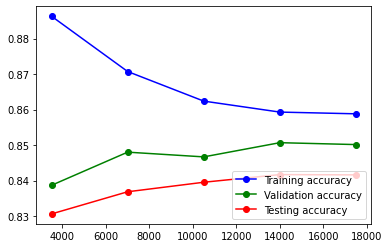

In [12]:
from sklearn.metrics import accuracy_score
def custom_learning_curve(x_train, y_train,
                          x_val, y_val, x_test, y_test,
                          n_splits):
  
  split_size = int(len(x_train) / n_splits)
  x_splits = np.split(x_train, n_splits) # must be equal division
  y_splits = np.split(y_train, n_splits)
  train_accuracies = list()
  val_accuracies = list()
  test_accuracies = list()
  curr_x = x_splits[0]
  print(curr_x.shape)
  curr_y = y_splits[0]
  print(curr_y.shape)
  nb = BernoulliNB()
  nb.fit(curr_x, curr_y)
  train_accuracies.append(accuracy_score(curr_y, 
                                         nb.predict(curr_x)))
  
  val_accuracies.append(accuracy_score(y_val, nb.predict(x_val)))
  test_accuracies.append(accuracy_score(y_test, nb.predict(x_test)))

  for i in range(1, len(x_splits)):
    nb = BernoulliNB()
    curr_x = np.concatenate((curr_x, x_splits[i]), axis=0)
    print(curr_x.shape)
    curr_y = np.concatenate((curr_y, y_splits[i]), axis=0)
    print(curr_y.shape)
    nb.fit(curr_x, curr_y)

    train_accuracies.append(accuracy_score(curr_y, 
                                           nb.predict(curr_x)))
    
    val_accuracies.append(accuracy_score(y_val, nb.predict(x_val)))

    test_accuracies.append(accuracy_score(y_test, nb.predict(x_test)))

  plt.plot(list(range(split_size, len(x_train) + split_size, 
                      split_size)), train_accuracies, 'o-', color="b",
             label="Training accuracy")
  plt.plot(list(range(split_size, len(x_train) + split_size, 
                      split_size)), val_accuracies, 'o-', color="green",
           label="Validation accuracy")
  plt.plot(list(range(split_size, len(x_train) + split_size, 
                      split_size)), test_accuracies, 'o-', color="red",
           label="Testing accuracy")
  plt.legend(loc="lower right")
  plt.show()

custom_learning_curve(x_train=x_train_binary , y_train=y_train,
                      x_val=x_dev_binary, y_val=y_dev, x_test=x_test_binary,
                      y_test=y_test, n_splits=5)

##Class Logistic Regression Stochastic Gradient Ascent with λ Regularization

In [13]:
class LogisticRegressionSGA:
    def __init__(self, h=0.01, max_iter=200,lamb=0.01):
        self.h = h
        self.max_iter = max_iter
        self.lamb=lamb

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])#vector w
        for i in range(self.max_iter):
            z = np.dot(X, self.w)#w*x
            y_pred = self.sigmoid(z)#P(c|x+) with sigmoid
            gradient = np.mean((y-y_pred)*X.T, axis=1)+(self.lamb * self.w **2)#calculate ∇l(w)+ regularization
            self.w += self.h * gradient #η*∇l(w) and we add(+) w because is an Ascent 
    
    def predict(self, X):
        predictions = []
        for x in X:
            y_pred = self.sigmoid(np.dot(x, self.w))
            predictions.append(1 if y_pred >= 0.5 else 0)
        return predictions

(3500, 3998)
(3500,)
(7000, 3998)
(7000,)
(10500, 3998)
(10500,)
(14000, 3998)
(14000,)
(17500, 3998)
(17500,)


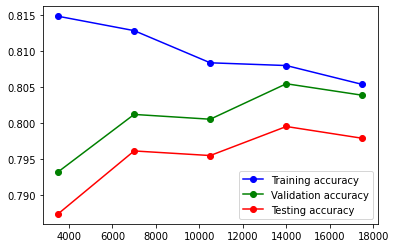

In [14]:
from sklearn.metrics import accuracy_score
def custom_learning_curve(x_train, y_train,
                          x_val, y_val, x_test, y_test,
                          n_splits):
  
  split_size = int(len(x_train) / n_splits)
  x_splits = np.split(x_train, n_splits) # must be equal division
  y_splits = np.split(y_train, n_splits)
  train_accuracies = list()
  val_accuracies = list()
  test_accuracies = list()
  curr_x = x_splits[0]
  print(curr_x.shape)
  curr_y = y_splits[0]
  print(curr_y.shape)
  lsga =  LogisticRegressionSGA()
  lsga.fit(curr_x, curr_y)
  train_accuracies.append(accuracy_score(curr_y, 
                                         lsga.predict(curr_x)))
  
  val_accuracies.append(accuracy_score(y_val, lsga.predict(x_val)))
  test_accuracies.append(accuracy_score(y_test, lsga.predict(x_test)))

  for i in range(1, len(x_splits)):
    lsga =  LogisticRegressionSGA()
    curr_x = np.concatenate((curr_x, x_splits[i]), axis=0)
    print(curr_x.shape)
    curr_y = np.concatenate((curr_y, y_splits[i]), axis=0)
    print(curr_y.shape)
    lsga.fit(curr_x, curr_y)

    train_accuracies.append(accuracy_score(curr_y, 
                                           lsga.predict(curr_x)))
    
    val_accuracies.append(accuracy_score(y_val, lsga.predict(x_val)))

    test_accuracies.append(accuracy_score(y_test, lsga.predict(x_test)))

  plt.plot(list(range(split_size, len(x_train) + split_size, 
                      split_size)), train_accuracies, 'o-', color="b",
             label="Training accuracy")
  plt.plot(list(range(split_size, len(x_train) + split_size, 
                      split_size)), val_accuracies, 'o-', color="green",
           label="Validation accuracy")
  plt.plot(list(range(split_size, len(x_train) + split_size, 
                      split_size)), test_accuracies, 'o-', color="red",
           label="Testing accuracy")
  plt.legend(loc="lower right")
  plt.show()

custom_learning_curve(x_train=x_train_binary , y_train=y_train,
                      x_val=x_dev_binary, y_val=y_dev, x_test=x_test_binary,
                      y_test=y_test, n_splits=5)

In [15]:
lsga = LogisticRegressionSGA()
lsga.fit(x_train_binary, y_train)
from sklearn.metrics import classification_report
print(classification_report(y_test, lsga.predict(x_test_binary)))

              precision    recall  f1-score   support

           0       0.79      0.80      0.80     12500
           1       0.80      0.79      0.80     12500

    accuracy                           0.80     25000
   macro avg       0.80      0.80      0.80     25000
weighted avg       0.80      0.80      0.80     25000



##logistic Sklearn

In [16]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(solver='saga')
log.fit(x_train_binary, y_train)

print(classification_report(y_test, log.predict(x_test_binary)))

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

           0       0.86      0.86      0.86     12500
           1       0.86      0.86      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



(3500, 3998)
(3500,)


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


(7000, 3998)
(7000,)


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


(10500, 3998)
(10500,)


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


(14000, 3998)
(14000,)


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


(17500, 3998)
(17500,)


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


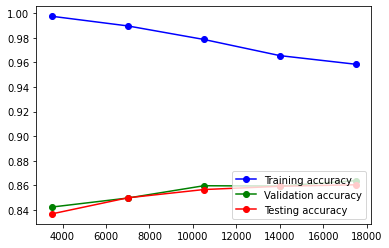

In [17]:
from sklearn.metrics import accuracy_score
def custom_learning_curve(x_train, y_train,
                          x_val, y_val, x_test, y_test,
                          n_splits):
  
  split_size = int(len(x_train) / n_splits)
  x_splits = np.split(x_train, n_splits) # must be equal division
  y_splits = np.split(y_train, n_splits)
  train_accuracies = list()
  val_accuracies = list()
  test_accuracies = list()
  curr_x = x_splits[0]
  print(curr_x.shape)
  curr_y = y_splits[0]
  print(curr_y.shape)
  log = LogisticRegression(solver='saga')
  log.fit(curr_x, curr_y)
  train_accuracies.append(accuracy_score(curr_y, 
                                         log.predict(curr_x)))
  
  val_accuracies.append(accuracy_score(y_val, log.predict(x_val)))
  test_accuracies.append(accuracy_score(y_test, log.predict(x_test)))

  for i in range(1, len(x_splits)):
    log = LogisticRegression(solver='saga')
    curr_x = np.concatenate((curr_x, x_splits[i]), axis=0)
    print(curr_x.shape)
    curr_y = np.concatenate((curr_y, y_splits[i]), axis=0)
    print(curr_y.shape)
    log.fit(curr_x, curr_y)

    train_accuracies.append(accuracy_score(curr_y, 
                                           log.predict(curr_x)))
    
    val_accuracies.append(accuracy_score(y_val, log.predict(x_val)))

    test_accuracies.append(accuracy_score(y_test, log.predict(x_test)))

  plt.plot(list(range(split_size, len(x_train) + split_size, 
                      split_size)), train_accuracies, 'o-', color="b",
             label="Training accuracy")
  plt.plot(list(range(split_size, len(x_train) + split_size, 
                      split_size)), val_accuracies, 'o-', color="green",
           label="Validation accuracy")
  plt.plot(list(range(split_size, len(x_train) + split_size, 
                      split_size)), test_accuracies, 'o-', color="red",
           label="Testing accuracy")
  plt.legend(loc="lower right")
  plt.show()

custom_learning_curve(x_train=x_train_binary , y_train=y_train,
                      x_val=x_dev_binary, y_val=y_dev, x_test=x_test_binary,
                      y_test=y_test, n_splits=5)

## Part C

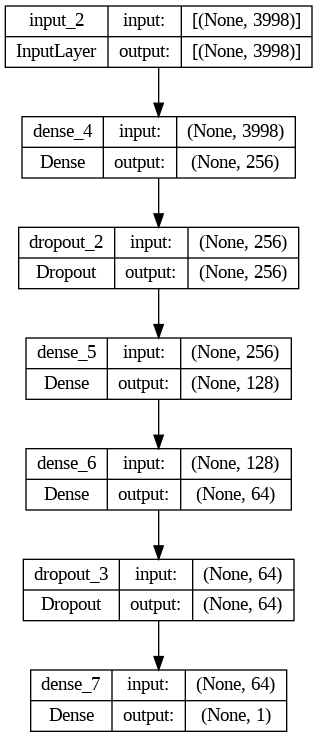

In [52]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image 

imdb_mlp = tf.keras.models.Sequential([
      tf.keras.layers.Input(shape=(3998,)),
      tf.keras.layers.Dense(units=256, activation='relu'),
      tf.keras.layers.Dropout(rate=0.2),
      tf.keras.layers.Dense(units=128, activation='relu'),
      tf.keras.layers.Dense(units=64, activation='relu'),
      tf.keras.layers.Dropout(rate=0.5),
      tf.keras.layers.Dense(units=1, activation='sigmoid')
])

plot_model(imdb_mlp, to_file='model.png', show_shapes=True)
Image('model.png')

In [53]:
imdb_mlp.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                  optimizer=tf.keras.optimizers.SGD(),
                  metrics=['binary_accuracy'])
imdb_mlp.fit(x=x_train_binary, y=y_train,
             epochs=10, verbose=1, batch_size=32)

Epoch 1/10
547/547 [==============================] - 5s 9ms/step - loss: 0.6764 - binary_accuracy: 0.5769
Epoch 2/10
547/547 [==============================] - 4s 8ms/step - loss: 0.5257 - binary_accuracy: 0.7584
Epoch 3/10
547/547 [==============================] - 5s 9ms/step - loss: 0.3975 - binary_accuracy: 0.8308
Epoch 4/10
547/547 [==============================] - 4s 8ms/step - loss: 0.3344 - binary_accuracy: 0.8641
Epoch 5/10
547/547 [==============================] - 4s 8ms/step - loss: 0.2971 - binary_accuracy: 0.8808
Epoch 6/10
547/547 [==============================] - 4s 8ms/step - loss: 0.2688 - binary_accuracy: 0.8948
Epoch 7/10
547/547 [==============================] - 4s 8ms/step - loss: 0.2447 - binary_accuracy: 0.9058
Epoch 8/10
547/547 [==============================] - 4s 8ms/step - loss: 0.2264 - binary_accuracy: 0.9158
Epoch 9/10
547/547 [==============================] - 4s 8ms/step - loss: 0.2021 - binary_accuracy: 0.9267
Epoch 10/10
547/547 [================

In [54]:
print(imdb_mlp.evaluate(x_test_binary, y_test))

782/782 [==============================] - 4s 5ms/step - loss: 0.3149 - binary_accuracy: 0.8755
[0.3148704767227173, 0.8754799962043762]


In [60]:
imdb_mlp.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                  metrics=['accuracy'], optimizer=tf.keras.optimizers.SGD())


In [64]:
mlp_history = imdb_mlp.fit(x_train_binary, y_train, batch_size=32, 
                                  epochs=10, validation_split=0.2)

Epoch 1/10
438/438 [==============================] - 4s 9ms/step - loss: 0.1008 - accuracy: 0.9727 - val_loss: 0.2754 - val_accuracy: 0.8994
Epoch 2/10
438/438 [==============================] - 4s 9ms/step - loss: 0.0864 - accuracy: 0.9754 - val_loss: 0.2869 - val_accuracy: 0.8963
Epoch 3/10
438/438 [==============================] - 4s 9ms/step - loss: 0.0764 - accuracy: 0.9814 - val_loss: 0.3050 - val_accuracy: 0.9049
Epoch 4/10
438/438 [==============================] - 4s 9ms/step - loss: 0.0647 - accuracy: 0.9841 - val_loss: 0.3159 - val_accuracy: 0.9011
Epoch 5/10
438/438 [==============================] - 4s 9ms/step - loss: 0.0584 - accuracy: 0.9863 - val_loss: 0.3264 - val_accuracy: 0.9009
Epoch 6/10
438/438 [==============================] - 4s 9ms/step - loss: 0.0547 - accuracy: 0.9866 - val_loss: 0.3573 - val_accuracy: 0.9046
Epoch 7/10
438/438 [==============================] - 4s 9ms/step - loss: 0.0454 - accuracy: 0.9896 - val_loss: 0.4040 - val_accuracy: 0.8963
Epoch 

In [65]:
def plot(his, kind):
  train = his.history[kind]
  val = his.history["val_"+  kind]
  epochs = range(1, len(train)+1)
  plt.figure(figsize=(12,9))
  plt.plot(epochs, train, 'b', label='Training ' + kind)
  plt.plot(epochs, val, 'orange', label='Validation ' + kind)
  plt.title('Training and validation ' + kind) 
  plt.xlabel('Epochs')
  plt.ylabel(kind)
  # x1, x2, y1, y2 = plt.axis()  
  # plt.axis((x1, x2, 0, 0.2))
  plt.legend()
  plt.show()

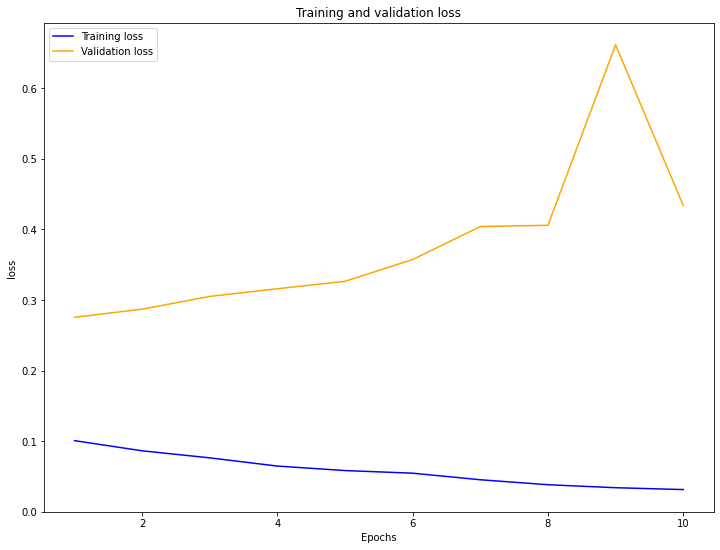

In [66]:
plot(mlp_history, 'loss')

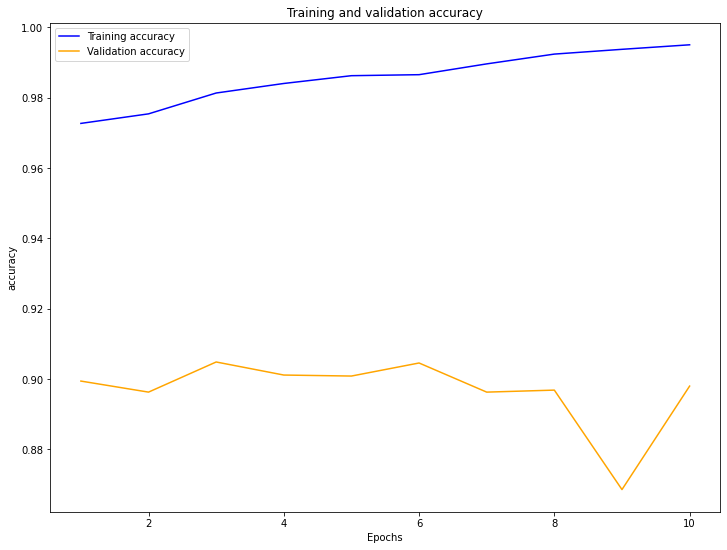

In [67]:
plot(mlp_history, 'accuracy')

In [68]:
y_pred = imdb_mlp.predict(x_test_binary)


print(classification_report(y_test, y_pred.round()))

782/782 [==============================] - 3s 4ms/step
              precision    recall  f1-score   support

           0       0.88      0.84      0.86     12500
           1       0.84      0.89      0.87     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

